In [1]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# The function get_label_from_par reads a .par file and returns 
# True if either the second or fourth item is not 'nan', 
# indicating the presence of an E-region in the corresponding image,
# for use in binary classification.

def get_label_from_par(par_file_path):
    try:
        # Open the .par file located at par_file_path
        with open(par_file_path, 'r') as file:
            content = file.readline().strip()  # Read and strip the first line of the file
            items = content.split()  # Split the line into individual items (usually numbers or 'nan')

            # Check the second (index 1) and fourth (index 3) items:
            # If either of these items is not 'nan', it implies the presence of an E-region.
            # The function then returns True, indicating that this image has an E-region.
            is_e_region = items[1].lower() != 'nan' or items[3].lower() != 'nan'
        return is_e_region

    except IndexError:
        # This block catches an IndexError, which occurs if the line read from the file
        # does not have at least four items. In such a case, the function assumes that
        # the E-region data is not present or not properly formatted, and returns False.
        return False

    except Exception as e:
        # This block catches any other exceptions (like file not found, read errors, etc.).
        # It prints the exception message and returns False, indicating an issue with processing the file.
        print(f"Error reading {par_file_path}: {e}")
        return False

## 2 - Test the performance of NOIRE-Net on an independent test set

### 2.1 - Define a function to get ionogram labels from the testing data 

In [3]:
# This code defines the get_majority_label function which determines the majority label 
# (True or False) among a list of .par files, and in case of a tie, it randomly selects a label.
def get_majority_label(par_files):
    # Extract labels from each .par file using the get_label_from_par function
    labels = [get_label_from_par(f) for f in par_files]

    # If the majority of labels are True, return True
    if labels.count(True) > len(labels) / 2:
        return True
    # If the majority of labels are False, return False
    elif labels.count(False) > len(labels) / 2:
        return False
    # If there is a tie between True and False labels, randomly choose one
    else:
        return random.choice([True, False])  # Randomize in case of a tie

### 2.2 - Define a function to load and process test images

In [4]:
# This code defines the load_and_preprocess_image function, which loads an image from a 
# specified path, converts it to grayscale, resizes it to 310x310 pixels, normalizes its pixel
# values, and returns the processed image as an array.
def load_and_preprocess_image(image_path):
    # Load the image from the given path, convert it to grayscale, and resize it to 310x310 pixels
    image = load_img(image_path, color_mode='grayscale', target_size=(310, 310))

    # Convert the image to a numpy array
    image = img_to_array(image)

    # Normalize the pixel values to be in the range [0, 1]
    image /= 255.0

    # Return the preprocessed image
    return image

### 2.3 - Load the trained models with the highest validation accuracy 

In [5]:
def load_models(models_dir):
    return [load_model(os.path.join(models_dir, mf)) for mf in os.listdir(models_dir) if mf.endswith('.h5')]

### 2.4 - Define a function to prepare the resting data for comparison with CNNs

In [6]:
# This function prepares the testing dataset by loading and processing images from a 
# specified directory and determining corresponding human labels based on majority voting
# from associated .par files.
def prepare_test_data(ionograms_dir, parameters_dir):
    X_test = []  # List to store preprocessed images
    y_human = []  # List to store corresponding human labels

    # Cache the paths of all .par files for efficient access
    par_files_cache = {f: os.path.join(parameters_dir, f) for f in os.listdir(parameters_dir)}

    # Iterate through each image file in the ionograms directory
    for img_file in os.listdir(ionograms_dir):
        if img_file.endswith('.png'):  # Only process .png files
            img_path = os.path.join(ionograms_dir, img_file)
            X_test.append(load_and_preprocess_image(img_path))  # Load and preprocess the image

            # Extract timestamp from the image filename
            timestamp = os.path.splitext(img_file)[0]

            # Get all .par files relevant to the current image based on timestamp
            relevant_par_files = [fpath for fname, fpath in par_files_cache.items() if timestamp in fname]
            y_human.append(get_majority_label(relevant_par_files))  # Determine the majority label

    # Convert lists to numpy arrays
    return np.array(X_test), np.array(y_human).astype(int)

### 2.5 - Define a function compare the CNN predictions to the human labeling

In [7]:
# This function evaluates a list of pre-loaded CNN models on a prepared test dataset, calculates key
# performance metrics (precision, recall, F1-score, accuracy), prints their mean and standard deviation,
# and returns the normalized confusion matrices for each model.
def evaluate_models(models, X_test, y_human):
    metrics = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}  # Dictionary to store metrics for each model
    confusion_matrices = []  # List to store confusion matrices for each model

    # Iterate over each model and evaluate it
    for model in models:
        y_pred = model.predict(X_test).round().astype(int)  # Predict labels for the test dataset

        # Calculate and store the performance metrics for the current model
        metrics['precision'].append(precision_score(y_human, y_pred))
        metrics['recall'].append(recall_score(y_human, y_pred))
        metrics['f1'].append(f1_score(y_human, y_pred))
        metrics['accuracy'].append(accuracy_score(y_human, y_pred))

        # Calculate and store the normalized confusion matrix
        confusion_matrices.append(confusion_matrix(y_human, y_pred, normalize='true'))

    # Print the mean and standard deviation for each metric
    for metric, values in metrics.items():
        print(f"Mean {metric.capitalize()}: {np.mean(values):.3f}, Std {metric.capitalize()}: {np.std(values):.3f}")

    return confusion_matrices


### 2.6 - Define the directories for the trained models and the testing data 

In [8]:
# Specify the directory where the trained models are stored
models_dir = 'E-classify'

# Specify the directory where the testing data is located
testing_dir = 'testing'

# Specify the directory where the input ionograms are located
ionograms_dir = os.path.join(testing_dir, 'ionograms')

# Specify the directory where the output parameters are located
parameters_dir = os.path.join(testing_dir, 'parameters')

X_test, y_human = prepare_test_data(ionograms_dir, parameters_dir)

models = load_models(models_dir)

2023-11-28 20:36:35.287886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 20:36:35.288044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


### 2.7 - Evaluate the models using precision, recall, F1-score, accuracy

In [9]:
# Evaluate the models located in 'models_dir' using the test data in 'testing_dir'
# and store the returned confusion matrices
confusion_matrices = evaluate_models(models, X_test, y_human)

2023-11-28 20:36:39.675971: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-28 20:36:39.862142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 63ms/step


2023-11-28 20:36:42.028252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 63ms/step


2023-11-28 20:36:43.762322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 72ms/step


2023-11-28 20:36:45.633599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 74ms/step


2023-11-28 20:36:47.523642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 76ms/step


2023-11-28 20:36:49.473863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 76ms/step


2023-11-28 20:36:51.391915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 98ms/step


2023-11-28 20:36:53.899856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 83ms/step


2023-11-28 20:36:56.041233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 94ms/step
Mean Precision: 0.972, Std Precision: 0.010
Mean Recall: 0.973, Std Recall: 0.007
Mean F1: 0.973, Std F1: 0.003
Mean Accuracy: 0.964, Std Accuracy: 0.005


### 2.8 - Calculate the mean and standard deviation of TP, FN, FP and TN

In [10]:
# Convert list of confusion matrices to a 3D NumPy array for easier calculations
confusion_matrices = np.array(confusion_matrices)

# Calculate mean and standard deviation for TP, FN, FP, TN
mean_tp = np.mean(confusion_matrices[:, 1, 1])
std_tp = np.std(confusion_matrices[:, 1, 1])

mean_fn = np.mean(confusion_matrices[:, 1, 0])
std_fn = np.std(confusion_matrices[:, 1, 0])

mean_fp = np.mean(confusion_matrices[:, 0, 1])
std_fp = np.std(confusion_matrices[:, 0, 1])

mean_tn = np.mean(confusion_matrices[:, 0, 0])
std_tn = np.std(confusion_matrices[:, 0, 0])

# Metrics, means, and standard deviations
means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

## 3 - Display the confusion matrix 

### 3.1 - Define Function for Text Color Based on Background

In [11]:
# This function determines the text color (black or white) based on the background color's
# luminance for better readability.
def text_color_based_on_bg(bg_color):
    # Calculate the perceptual luminance of the color
    luminance = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
    return 'white' if luminance < 0.5 else 'black'

### 3.2 - Plot the Confusion Matrix Statistics

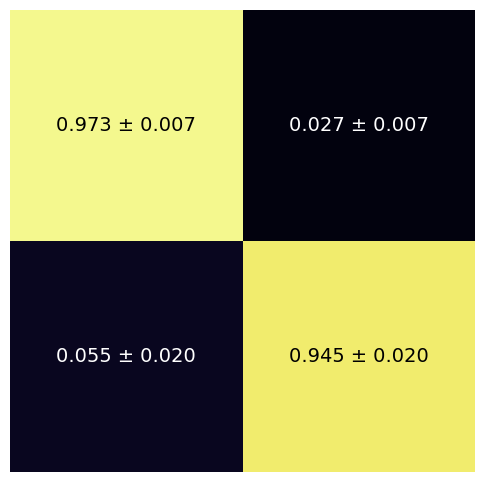

In [12]:
# This code creates a 2x2 plot with colored squares representing the mean and standard 
# deviation of TP, FN, FP, and TN from the confusion matrices.

# Setup color map and normalization
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()

means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

# Iterate over each subplot to add the confusion matrix data
for i, ax in enumerate(axs):
    color = cmap(norm(means[i]))  # Set the color based on the mean value
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))  # Create a colored square

    text_color = text_color_based_on_bg(color)  # Determine text color
    text = f'{means[i]:.3f} ± {std_devs[i]:.3f}'  # Format text for mean ± std deviation
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=14, color=text_color)  # Add text to the subplot

    ax.axis('off')  # Remove axes

plt.subplots_adjust(wspace=0, hspace=0)  # Adjust layout
plt.show()



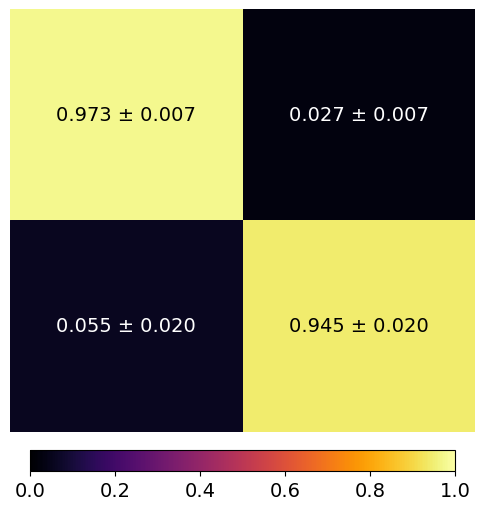

In [13]:
# Setup color map with normalization between 0 and 1
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a 2x2 subplot figure with adjusted spacing
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()

means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

# Iterate over each subplot to add the confusion matrix data
for i, ax in enumerate(axs):
    color = cmap(norm(means[i]))  # Set the color based on the mean value
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))  # Create a colored square

    text_color = text_color_based_on_bg(color)  # Determine text color
    text = f'{means[i]:.3f} ± {std_devs[i]:.3f}'  # Format text for mean ± std deviation
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=14, color=text_color)  # Add text to the subplot

    ax.axis('off')  # Remove axes

# Adjust subplot parameters so squares touch each other
plt.subplots_adjust(wspace=0, hspace=0)

# Add a colorbar and adjust its font size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=14)  # Set font size for colorbar ticks

plt.show()




In [14]:
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score, accuracy_score


In [15]:
def load_human_labels(parameters_dir, experts):
    # Initialize a dictionary to store labels for each image
    human_labels = {}

    # Iterate through each file in the parameters directory
    for img_file in os.listdir(parameters_dir):
        if img_file.endswith('.par'):
            # Extract the expert's name and the timestamp from the file name
            expert = img_file[:3]
            if expert in experts:
                timestamp = img_file[4:].split('.')[0]

                # Initialize the label structure for this timestamp if not already done
                if timestamp not in human_labels:
                    human_labels[timestamp] = {ex: None for ex in experts}

                # Read the label from the .par file
                human_labels[timestamp][expert] = get_label_from_par(os.path.join(parameters_dir, img_file))
    return human_labels


In [16]:
def calculate_human_metrics(human_labels, experts):
    # Initialize lists to store metrics for each pair of human experts
    kappa_scores, precisions, recalls, f1s, accuracies = [], [], [], [], []

    # Iterate over each pair of human experts and calculate metrics
    for i, expert1 in enumerate(experts):
        for expert2 in experts[i+1:]:
            expert1_labels, expert2_labels = [], []

            # Collect labels for comparison
            for timestamp, labels in human_labels.items():
                if labels[expert1] is not None and labels[expert2] is not None:
                    expert1_labels.append(labels[expert1])
                    expert2_labels.append(labels[expert2])

            # Calculate and store metrics if there are labels to compare
            if expert1_labels and expert2_labels:
                kappa_scores.append(cohen_kappa_score(expert1_labels, expert2_labels))
                precisions.append(precision_score(expert1_labels, expert2_labels))
                recalls.append(recall_score(expert1_labels, expert2_labels))
                f1s.append(f1_score(expert1_labels, expert2_labels))
                accuracies.append(accuracy_score(expert1_labels, expert2_labels))

    # Calculate and return mean and standard deviation for each metric
    return {
        'kappa': (np.mean(kappa_scores), np.std(kappa_scores)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1s), np.std(f1s)),
        'accuracy': (np.mean(accuracies), np.std(accuracies))
    }


In [17]:
experts = ['akv', 'asp', 'dhu', 'jvi', 'trx']
parameters_dir = 'path_to_parameters_dir'
human_labels = load_human_labels(parameters_dir, experts)

In [18]:
human_metrics = calculate_human_metrics(human_labels, experts)
print("Human vs Human Performance:")
for metric, (mean, std) in human_metrics.items():
    print(f"{metric.capitalize()} - Mean: {mean:.3f}, Std: {std:.3f}")


Human vs Human Performance:
Kappa - Mean: 0.879, Std: 0.026
Precision - Mean: 0.953, Std: 0.026
Recall - Mean: 0.962, Std: 0.024
F1 - Mean: 0.957, Std: 0.011
Accuracy - Mean: 0.944, Std: 0.013
